In [1]:
pip install datasets

In [2]:
pip install keras-tuner

In [48]:
from datasets import load_dataset

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from PIL import UnidentifiedImageError

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

from kerastuner import HyperModel, RandomSearch

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

In [4]:
from datasets import load_dataset

# load dataset
dataset = load_dataset('Falah/Alzheimer_MRI')

# check the structure of the dataset
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5120
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1280
    })
})


In [5]:
# convert dataset to a pandas DataFrame for easier manipulation
df = pd.DataFrame(dataset['train'])

print(df.head())

                                               image  label
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...      2
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...      0
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...      3
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...      3
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...      2


**DATA EXPLORATION**

In [6]:
# check distribution of classes
class_distribution = df['label'].value_counts()
print("Class Distribution:\n", class_distribution)

Class Distribution:
 label
2    2566
3    1781
0     724
1      49
Name: count, dtype: int64


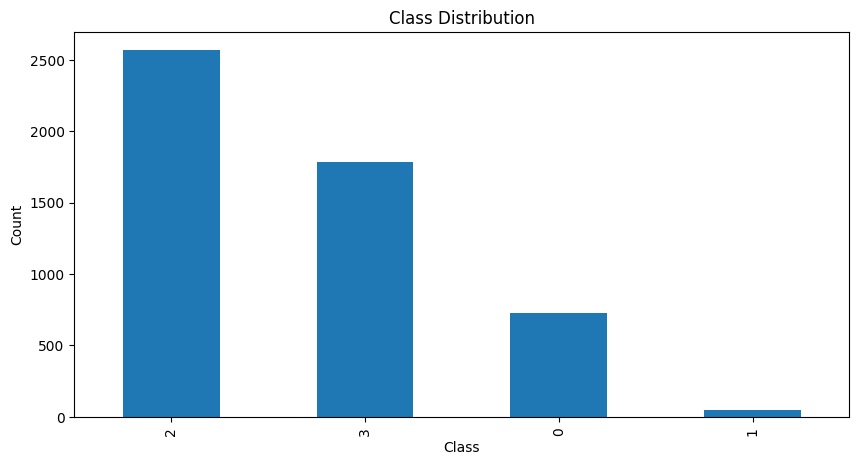

In [7]:
# plot class distribution
plt.figure(figsize=(10, 5))
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [8]:
# image column
print(df['image'].head())
print(type(df['image'][0]))

0    <PIL.JpegImagePlugin.JpegImageFile image mode=...
1    <PIL.JpegImagePlugin.JpegImageFile image mode=...
2    <PIL.JpegImagePlugin.JpegImageFile image mode=...
3    <PIL.JpegImagePlugin.JpegImageFile image mode=...
4    <PIL.JpegImagePlugin.JpegImageFile image mode=...
Name: image, dtype: object
<class 'PIL.JpegImagePlugin.JpegImageFile'>


In [9]:
# get dimensions of first image
img = df['image'][0]
img_array = np.array(img)
height, width = img_array.shape

print(f"Image dimensions: {height}x{width}")

Image dimensions: 128x128


In [10]:
# calculate pixel statistics
def get_pixel_statistics(image_path):
    img = df['image'][0]
    img_array = np.array(img)
    return {
        'mean': np.mean(img_array),
        'std': np.std(img_array),
        'min': np.min(img_array),
        'max': np.max(img_array)
    }

# statistics for the first few images
pixel_stats = [get_pixel_statistics(img_path) for img_path in df['image'][:10]]
pixel_stats_df = pd.DataFrame(pixel_stats)

print(pixel_stats_df)

        mean        std  min  max
0  47.227417  54.111822    0  157
1  47.227417  54.111822    0  157
2  47.227417  54.111822    0  157
3  47.227417  54.111822    0  157
4  47.227417  54.111822    0  157
5  47.227417  54.111822    0  157
6  47.227417  54.111822    0  157
7  47.227417  54.111822    0  157
8  47.227417  54.111822    0  157
9  47.227417  54.111822    0  157


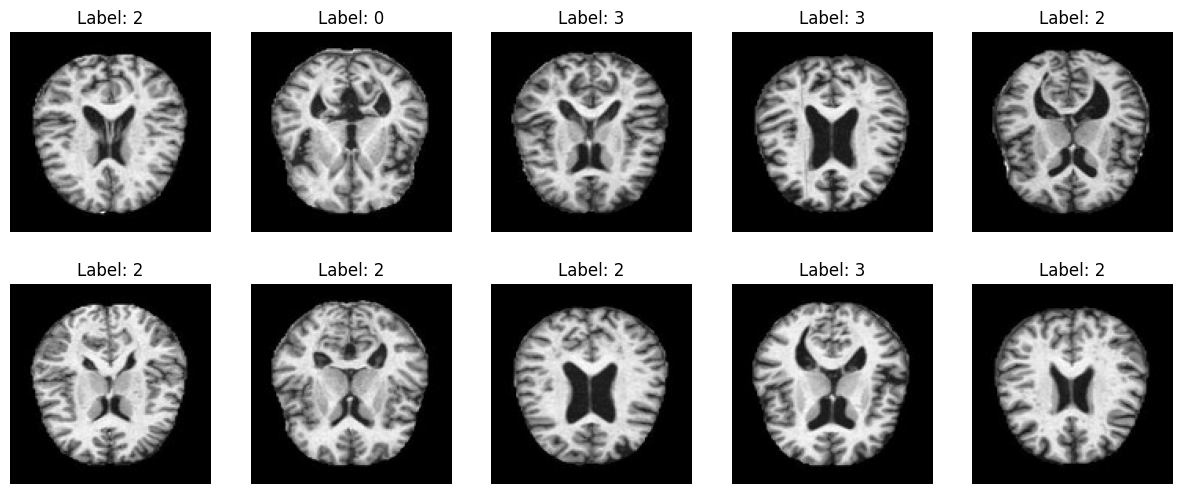

In [11]:
# sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    img = df['image'][i]
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {df['label'][i]}")
    ax.axis('off')
plt.show()


In [12]:
# check for missing values
print("Missing values in each column:\n", df.isnull().sum())

# check for duplicate images
print("Number of duplicate images:", df.duplicated(subset=['image']).sum())

Missing values in each column:
 image    0
label    0
dtype: int64
Number of duplicate images: 0


In [13]:
# check for corrupted images
corrupted_images = []
for i, img in enumerate(df['image']):
    try:
        img_array = np.array(img)  # Try converting the image to a NumPy array
    except (UnidentifiedImageError, IOError, Exception) as e:
        corrupted_images.append(i)

if corrupted_images:
    print(f"Corrupted images found at indices: {corrupted_images}")
else:
    print("No corrupted images found.")

No corrupted images found.


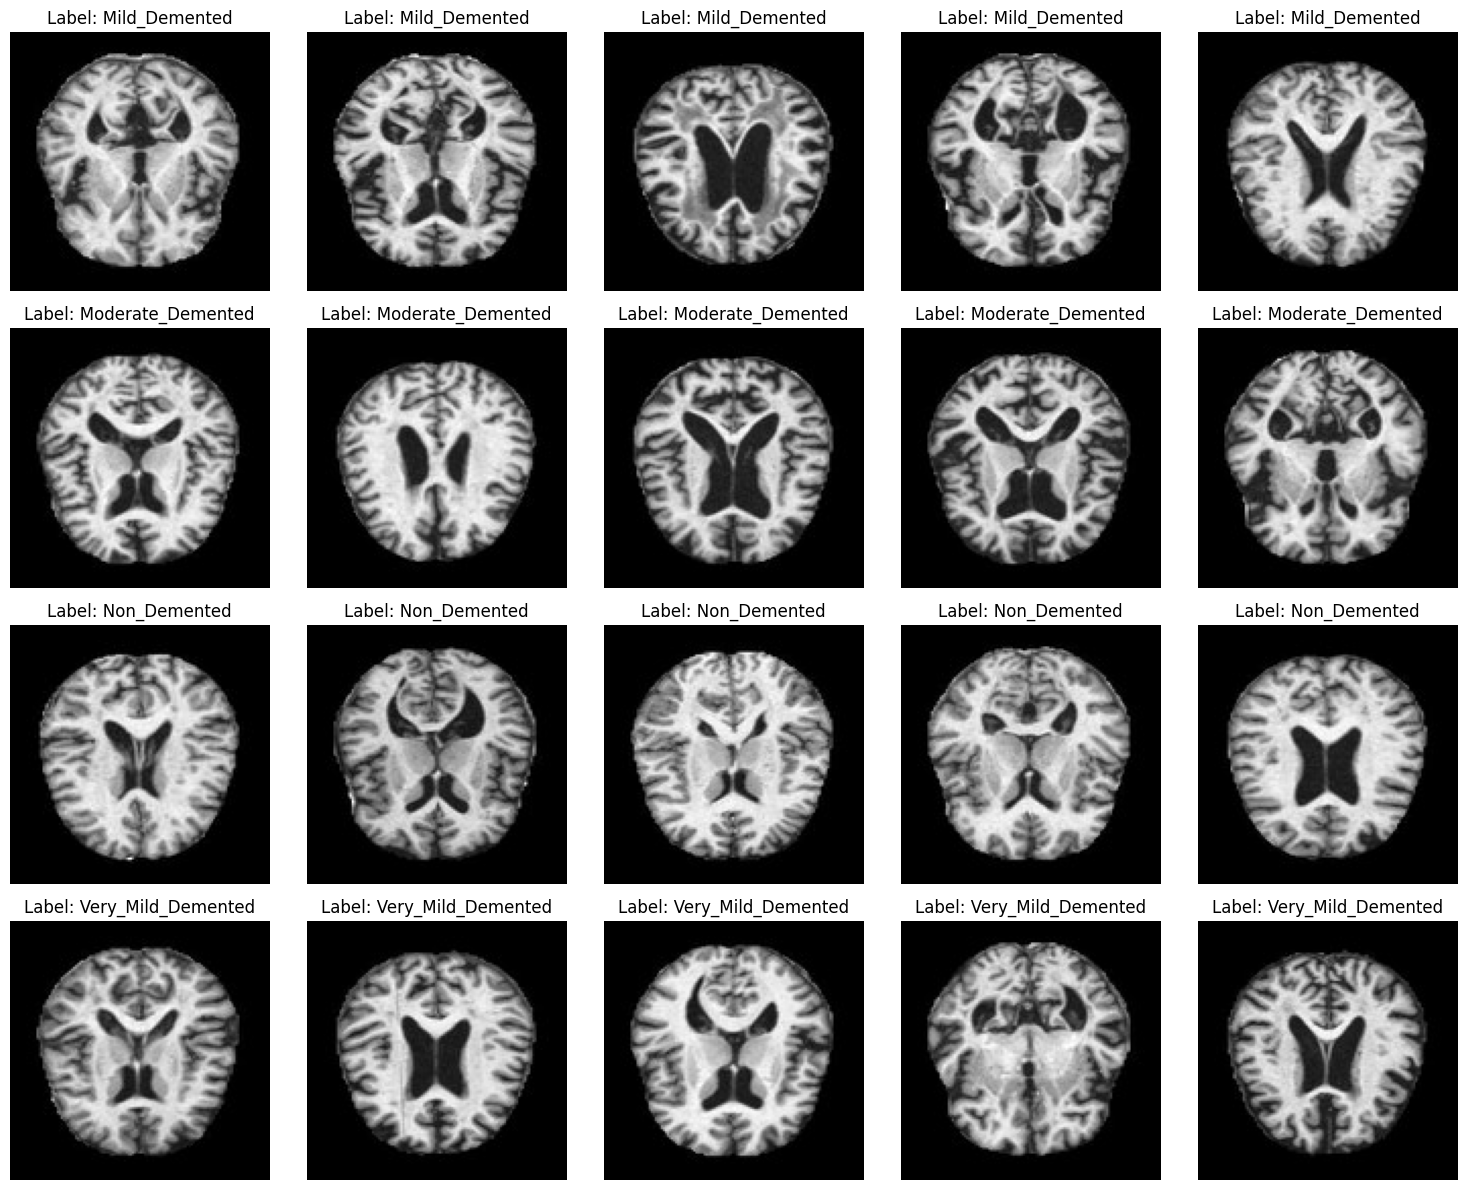

In [14]:
# label names
label_names = {
    0: 'Mild_Demented',
    1: 'Moderate_Demented',
    2: 'Non_Demented',
    3: 'Very_Mild_Demented'
}

# plot 5 samples for each label
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for label_idx, label_name in label_names.items():

    label_images = df[df['label'] == label_idx]['image'][:5]

    # plotimages
    for i, img in enumerate(label_images):
        ax = axes[label_idx, i]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Label: {label_name}")
        ax.axis('off')

plt.tight_layout()
plt.show()

**DATA PREPROCESSING**

In [15]:
# convert to rbg
images = np.array([np.array(img.convert('RGB').resize((128, 128))) for img in df['image']])
# one-hot encoding
labels = pd.get_dummies(df['label']).values

# split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# normalize images
X_train = X_train / 255.0
X_val = X_val / 255.0

In [16]:
# verify shape
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)

X_train shape: (4096, 128, 128, 3)
X_val shape: (1024, 128, 128, 3)
Training labels shape: (4096, 4)
Validation labels shape: (1024, 4)


In [17]:
# verify normalization
print("Training data - min:", X_train.min(), "max:", X_train.max())
print("Validation data - min:", X_val.min(), "max:", X_val.max())

Training data - min: 0.0 max: 1.0
Validation data - min: 0.0 max: 1.0


**BASELINE CNN MODEL**

In [18]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# train the model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.4982 - loss: 1.0429 - val_accuracy: 0.5664 - val_loss: 0.8687
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6039 - loss: 0.8587 - val_accuracy: 0.6240 - val_loss: 0.7768
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7231 - loss: 0.6154 - val_accuracy: 0.7949 - val_loss: 0.4773
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8660 - loss: 0.3479 - val_accuracy: 0.8525 - val_loss: 0.3703
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9295 - loss: 0.1818 - val_accuracy: 0.9102 - val_loss: 0.2255
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9768 - loss: 0.0685 - val_accuracy: 0.8359 - val_loss: 0.4479
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9767 - loss: 0.0676 - val_accuracy: 0.9453 - val_loss: 0.1672
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9954 - loss: 0.0179 - val_accuracy: 0

Baseline CNN Model Evaluation

In [20]:
# predict on the validation set

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [21]:
# classification report
print("Classification Report (Baseline Model):")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_names.values()))

Classification Report (Baseline Model):
                    precision    recall  f1-score   support

     Mild_Demented       0.75      0.96      0.84       136
 Moderate_Demented       1.00      1.00      1.00         5
      Non_Demented       0.99      0.83      0.90       533
Very_Mild_Demented       0.83      0.94      0.88       350

          accuracy                           0.89      1024
         macro avg       0.89      0.93      0.91      1024
      weighted avg       0.90      0.89      0.89      1024



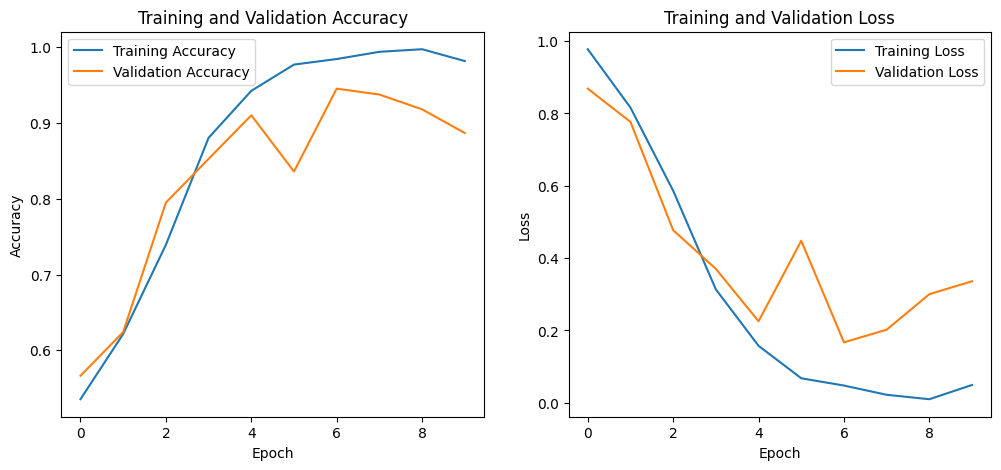

In [22]:
# plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

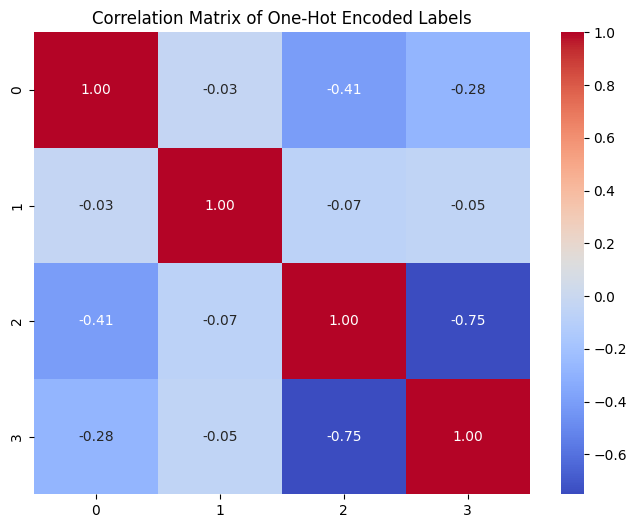

In [23]:
# correlation matrix
correlation_matrix = np.corrcoef(y_val.T)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of One-Hot Encoded Labels")
plt.show()

**CNN WITH DATA AUGMENTATION**

In [24]:
datagen = ImageDataGenerator(
    rotation_range=20, # randomly rotate images by 20 degrees
    width_shift_range=0.2, # randomly shift images horizontally by 20%
    height_shift_range=0.2, # randomly shift images vertically by 20%
    shear_range=0.1, # shear transformations
    zoom_range=0.2, # randomly zoom in/out by 20%
    horizontal_flip=True, # randomly flip images horizontally
    fill_mode='nearest' # fill in missing pixels with nearest value
)

# fit data augmentation generator to the training data
datagen.fit(X_train)

In [25]:
# rebuild baseline model
model_aug = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),  # input shape for RGB images
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

# compile the model
model_aug.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# model summary
model_aug.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# train the model with data augmentation
history_aug = model_aug.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_val, y_val)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - accuracy: 0.4610 - loss: 1.0998 - val_accuracy: 0.4912 - val_loss: 1.0050
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.4989 - loss: 1.0151 - val_accuracy: 0.5400 - val_loss: 0.9021
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.5361 - loss: 0.9564 - val_accuracy: 0.5508 - val_loss: 0.8706
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 110ms/step - accuracy: 0.5370 - loss: 0.9428 - val_accuracy: 0.5459 - val_loss: 0.8693
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.5585 - loss: 0.9271 - val_accuracy: 0.5400 - val_loss: 0.8713
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.5275 - loss: 0.9521 - val_accuracy: 0.5615 - val_loss: 0.8500
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - accuracy: 0.5677 - loss: 0.9185 - val_accuracy: 0.5488 - val_loss: 0.8589
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 109ms/step - accuracy: 0.5900 - loss: 0

CNN with Data Augmentation Model Evaluation

In [27]:
# predict on the validation set
y_pred_aug = model_aug.predict(X_val)
y_pred_classes_aug = np.argmax(y_pred_aug, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# classification report
print("Classification Report (Augmented Model):")
print(classification_report(y_true_classes, y_pred_classes_aug, target_names=label_names.values()))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Classification Report (Augmented Model):
                    precision    recall  f1-score   support

     Mild_Demented       0.30      0.85      0.44       136
 Moderate_Demented       0.00      0.00      0.00         5
      Non_Demented       0.80      0.55      0.65       533
Very_Mild_Demented       0.48      0.37      0.42       350

          accuracy                           0.52      1024
         macro avg       0.39      0.44      0.38      1024
      weighted avg       0.62      0.52      0.54      1024



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


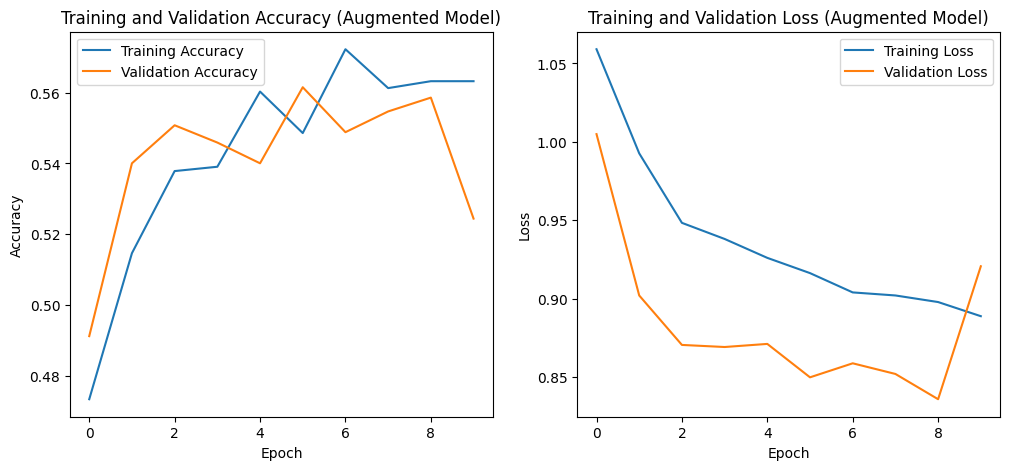

In [28]:
# plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Augmented Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_aug.history['loss'], label='Training Loss')
plt.plot(history_aug.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Augmented Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

**TRANSFER LEARNING**

In [29]:
# load VGG16 model with pre-trained weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Resize images to 224x224

# freeze the base model
base_model.trainable = False

# build the model on top of the base model
model_transfer = Sequential([
    base_model,
    GlobalAveragePooling2D(), # GlobalAveragePooling2D instead of Flatten
    Dense(128, activation='relu'),
    BatchNormalization(), # BatchNormalization for stability
    Dense(4, activation='softmax')
])

In [30]:
# compile the model with a lower learning rate
model_transfer.compile(optimizer=Adam(learning_rate=0.0001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# model summary
model_transfer.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,781,380 (56.39 MB)

 Trainable params: 66,436 (259.52 KB)

 Non-trainable params: 14,714,944 (56.13 MB)

In [31]:
# resize images to 224x224
X_train_resized = np.array([img_to_array(array_to_img(img).resize((224, 224))) for img in X_train])
X_val_resized = np.array([img_to_array(array_to_img(img).resize((224, 224))) for img in X_val])

# normalize the resized images
X_train_resized = X_train_resized / 255.0
X_val_resized = X_val_resized / 255.0

In [32]:
# train the model
history_transfer = model_transfer.fit(
    X_train_resized, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_resized, y_val)
)

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.3584 - loss: 1.4171 - val_accuracy: 0.3818 - val_loss: 1.3121
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5418 - loss: 1.1509 - val_accuracy: 0.5391 - val_loss: 1.1662
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6058 - loss: 1.0405 - val_accuracy: 0.5410 - val_loss: 1.1313
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6062 - loss: 0.9855 - val_accuracy: 0.5557 - val_loss: 1.0594
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6389 - loss: 0.9099 - val_accuracy: 0.6270 - val_loss: 0.9039
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6364 - loss: 0.8641 - val_accuracy: 0.5947 - val_loss: 0.9192
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6582 - loss: 0.8187 - val_accuracy: 0.6055 - val_loss: 0.9063
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6752 - loss: 0.7815 - val_acc

Transfer Learning Model Evaluation

In [33]:
# predict on the validation set
y_pred_transfer = model_transfer.predict(X_val_resized)
y_pred_classes_transfer = np.argmax(y_pred_transfer, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# classification report
print("Classification Report (Transfer Learning Model):")
print(classification_report(y_true_classes, y_pred_classes_transfer, target_names=label_names.values()))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Classification Report (Transfer Learning Model):
                    precision    recall  f1-score   support

     Mild_Demented       0.42      0.57      0.49       136
 Moderate_Demented       0.00      0.00      0.00         5
      Non_Demented       0.64      0.89      0.75       533
Very_Mild_Demented       0.70      0.21      0.32       350

          accuracy                           0.61      1024
         macro avg       0.44      0.42      0.39      1024
      weighted avg       0.63      0.61      0.56      1024



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


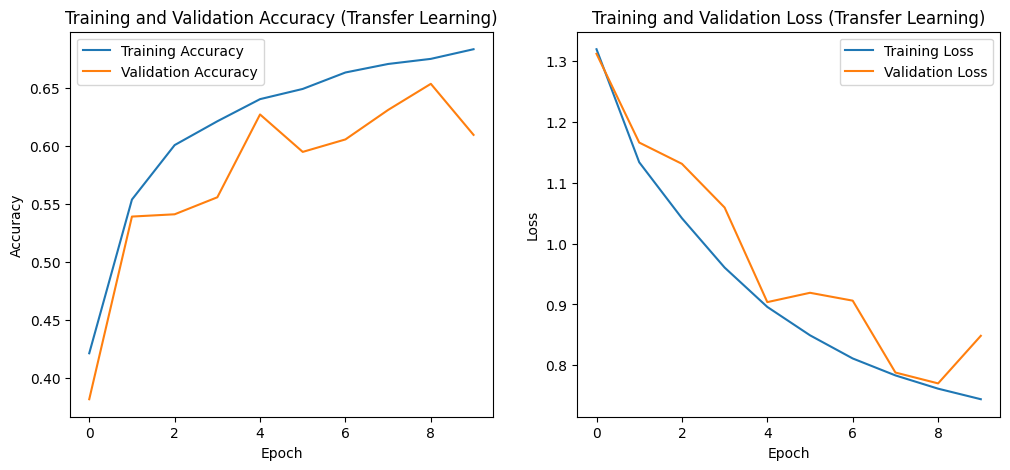

In [34]:
# plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_transfer.history['accuracy'], label='Training Accuracy')
plt.plot(history_transfer.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_transfer.history['loss'], label='Training Loss')
plt.plot(history_transfer.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Transfer Learning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Fine-Tune Model

In [35]:
# unfreeze last few layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# recompile model with a very low learning rate
model_transfer.compile(optimizer=Adam(learning_rate=0.00001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# fine-tune the model
history_fine_tune = model_transfer.fit(
    X_train_resized, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_resized, y_val)
)

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.7039 - loss: 0.7004 - val_accuracy: 0.7100 - val_loss: 0.6738
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8292 - loss: 0.4905 - val_accuracy: 0.7744 - val_loss: 0.5294
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.9055 - loss: 0.3545 - val_accuracy: 0.8330 - val_loss: 0.4278
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9506 - loss: 0.2597 - val_accuracy: 0.8584 - val_loss: 0.4208
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9754 - loss: 0.1947 - val_accuracy: 0.8848 - val_loss: 0.3025
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9835 - loss: 0.1493 - val_accuracy: 0.9180 - val_loss: 0.2477
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9928 - loss: 0.1093 - val_accuracy: 0.9326 - val_loss: 0.2387
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9956 - loss: 0.0900 - val_acc

Evaluate Fine-Tuned Model

In [36]:
# predict on the validation set
y_pred_fine_tuned = model_transfer.predict(X_val_resized)
y_pred_classes_fine_tuned = np.argmax(y_pred_fine_tuned, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [37]:
# classification report
print("Classification Report (After Fine-Tuning):")
print(classification_report(y_true_classes, y_pred_classes_fine_tuned, target_names=label_names.values()))

Classification Report (After Fine-Tuning):
                    precision    recall  f1-score   support

     Mild_Demented       0.86      0.96      0.91       136
 Moderate_Demented       1.00      1.00      1.00         5
      Non_Demented       0.96      0.97      0.97       533
Very_Mild_Demented       0.97      0.91      0.94       350

          accuracy                           0.95      1024
         macro avg       0.95      0.96      0.95      1024
      weighted avg       0.95      0.95      0.95      1024



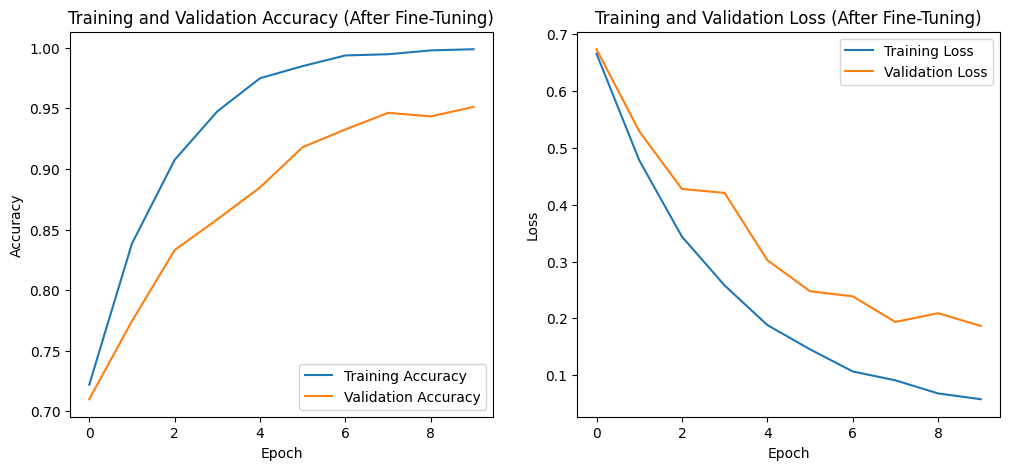

In [38]:
# plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_fine_tune.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (After Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_fine_tune.history['loss'], label='Training Loss')
plt.plot(history_fine_tune.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (After Fine-Tuning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

**HYPERPARAMETER TUNING MODEL**

In [39]:
# rebuild model with GlobalAveragePooling2D
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,276 (430.77 KB)

 Trainable params: 110,276 (430.77 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()

        # tune number of convolutional layers
        for i in range(hp.Int('num_conv_layers', 1, 3)):
            model.add(Conv2D(
                filters=hp.Int(f'filters_{i}', 32, 128, step=32),
                kernel_size=(3, 3),
                activation='relu',
                input_shape=self.input_shape if i == 0 else None
            ))
            model.add(MaxPooling2D(pool_size=(2, 2)))

        model.add(GlobalAveragePooling2D())

        # tune number of dense layers
        for i in range(hp.Int('num_dense_layers', 1, 2)):
            model.add(Dense(
                units=hp.Int(f'units_{i}', 64, 256, step=64),
                activation='relu'
            ))
            model.add(Dropout(rate=hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))

        # output layer
        model.add(Dense(self.num_classes, activation='softmax'))

        # tune learning rate
        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

        # compile the model
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

In [41]:
# define input shape and number of classes
input_shape = (128, 128, 3)
num_classes = 4

# initialize the hypermodel
hypermodel = CNNHyperModel(input_shape=input_shape, num_classes=num_classes)

# set up tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',  # maximize validation accuracy
    max_trials=10,
    executions_per_trial=2,
    directory='my_tuning_dir',
    project_name='alzheimer_cnn_tuning'
)

Reloading Tuner from my_tuning_dir/alzheimer_cnn_tuning/tuner0.json


In [42]:
tuner.search(
    X_train_resized, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val_resized, y_val)
)

Trial 10 Complete [00h 00m 51s]
val_accuracy: 0.5283203125

Best val_accuracy So Far: 0.53515625
Total elapsed time: 00h 23m 24s


In [43]:
# best model
best_model = tuner.get_best_models(num_models=1)[0]

# best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# print best hyperparameters
print("Best Hyperparameters:")
print(best_hyperparameters.values)

# evaluate the best model on the validation set
val_loss, val_accuracy = best_model.evaluate(X_val_resized, y_val)
print(f"Validation Accuracy: {val_accuracy}")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best Hyperparameters:
{'num_conv_layers': 1, 'filters_0': 64, 'num_dense_layers': 2, 'units_0': 192, 'dropout_0': 0.2, 'learning_rate': 0.01, 'filters_1': 96, 'filters_2': 96, 'units_1': 64, 'dropout_1': 0.2}
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5412 - loss: 0.9667
Validation Accuracy: 0.5361328125


In [44]:
history_hyperparameter = best_model.fit(
    X_train_resized, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val_resized, y_val)
)

Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5158 - loss: 0.9674 - val_accuracy: 0.5273 - val_loss: 0.8873
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5262 - loss: 0.9678 - val_accuracy: 0.5332 - val_loss: 0.9276
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4844 - loss: 1.0242 - val_accuracy: 0.5205 - val_loss: 1.0043
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5048 - loss: 1.0375 - val_accuracy: 0.5205 - val_loss: 1.0038
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4855 - loss: 1.0405 - val_accuracy: 0.5205 - val_loss: 1.0059
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4940 - loss: 1.0402 - val_accuracy: 0.5205 - val_loss: 1.0043
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5009 - loss: 1.0424 - val_accuracy: 0.5205 - val_loss: 1.0063
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4896 - loss: 1.0510 - val_accu

Evaluating Hyperparameter Model

In [45]:
# predict on the validation set
y_pred = best_model.predict(X_val_resized)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# generate the classification report
print("Classification Report (Best Model):")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_names.values()))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Classification Report (Best Model):
                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00       136
 Moderate_Demented       0.00      0.00      0.00         5
      Non_Demented       0.52      1.00      0.68       533
Very_Mild_Demented       0.00      0.00      0.00       350

          accuracy                           0.52      1024
         macro avg       0.13      0.25      0.17      1024
      weighted avg       0.27      0.52      0.36      1024



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


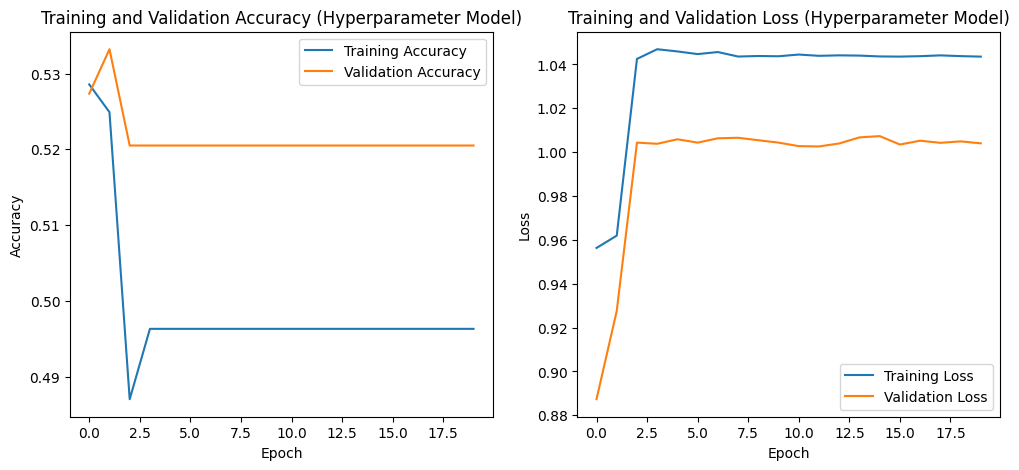

In [46]:
# plot training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_hyperparameter.history['accuracy'], label='Training Accuracy')
plt.plot(history_hyperparameter.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Hyperparameter Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history_hyperparameter.history['loss'], label='Training Loss')
plt.plot(history_hyperparameter.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Hyperparameter Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()